# Import

In [1]:
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD
import pandas as pd
import pymannkendall as mk
import seaborn as sns
from scipy.stats import gaussian_kde
from xmca.xarray import xMCA
from scipy.stats import linregress
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from scipy.signal import detrend as scipy_detrend
from sklearn.linear_model import LinearRegression
import regionmask
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone
from sklearn.metrics import make_scorer
import os
import statsmodels.api as sm
import subprocess

# Load

In [2]:
ds = xr.open_dataset('../data/spi3_cmap_1x1.nc')
spi = ds.rename_vars({list(ds.data_vars)[0]: 'spi'}).sortby('T').spi

spi = spi.rename({'X': 'lon','Y':'lat', 'T':'time'})

spi = spi.sel(time=slice('1981-01-01', '2020-12-31'))

mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi['lon'], spi['lat']
)

In [3]:
os.makedirs("figures", exist_ok=True)

In [4]:
#NOAA COBE SST data
sst = xr.open_dataset('../data/sst.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'))


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
#sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))
#select enso region
sst = sst.sel(lat=slice(30, -30), lon=slice(140, 290))

# GPH regressions

In [5]:
#NOAA COBE SST data
gph = xr.open_dataset('../data/hgt.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'),
                                                                  level=500,
                                                                    lat=slice(90, 0))
                                                                      #lon=slice(0, 100))

gph['hgt3m'] = gph['hgt'] + gph['hgt'].shift(time=1) + gph['hgt'].shift(time=2)

#put lon is -180 to 180
#gph = gph.assign_coords(lon=(((gph.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
gph = gph.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))

if not os.path.exists('figures/gph'):
    os.makedirs('figures/gph')

In [11]:
def svd_regression_gph(
    sst, spi, hpa, n_modes=1, detrend=False, month=None, 
    proj=ccrs.PlateCarree(), label=None, method='corr',
    norm_preds = True
):
    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        sst = sst.sel(time=sst['time.month'] == month_num)
        hpa = hpa.sel(time=hpa['time.month'] == month_num)
        spi = spi.sel(time=spi['time.month'] == month_num)

    def xr_detrend(da):
        return xr.apply_ufunc(
            scipy_detrend, da,
            input_core_dims=[['time']],
            output_core_dims=[['time']],
            vectorize=True, dask='parallelized', output_dtypes=[da.dtype]
        )

    def get_all_pcs(X, Y):
        if detrend:
            X = xr_detrend(X.fillna(0)).transpose('time', 'lat', 'lon')
            Y = xr_detrend(Y.fillna(0)).transpose('time', 'lat', 'lon')
        X = (X - X.mean('time')) / (X.std('time') + 1e-6)
        Y = (Y - Y.mean('time')) / (Y.std('time') + 1e-6)
        mca = xMCA(X.fillna(0), Y.fillna(0))
        mca.apply_coslat()
        mca.solve()
        left_pcs = mca.pcs()['left']
        right_pcs = mca.pcs()['right']
        nino_lon_bounds = (190, 240)  # 190E to 240E
        nino_lat_bounds = (5, -5)     # 5S to 5N

        left_map = mca.eofs()['left']

         # Calculate Nino3.4 anomaly

        nino34_anom = left_map.sel(mode=1).sel(
        lon=slice(nino_lon_bounds[0], nino_lon_bounds[1]),
        lat=slice(nino_lat_bounds[0], nino_lat_bounds[1]))
        
        # Take the mean over time (or specific month if already selected)
        mean_nino34 = nino34_anom.mean()
        print(f"Mean Nino3.4 anomaly for month {month}: {mean_nino34.values}")

        # Conditionally flip the sign based on Nino3.4 anomaly
        if mean_nino34 < 0:
            left_pcs = -left_pcs
            right_pcs = -right_pcs
        return left_pcs, right_pcs

    period = slice('1981-01-01', '2020-12-31')
    sst = sst.sel(time=period).transpose('time', 'lat', 'lon')
    spi = spi.sel(time=period).transpose('time', 'lat', 'lon')
    hpa = hpa.sel(time=period).transpose('time', 'lat', 'lon')

    pcs_sst, pcs_spi = get_all_pcs(sst, spi)
    #normalize the pcs
    if norm_preds:
        pcs_sst = (pcs_sst - pcs_sst.mean('time')) / (pcs_sst.std('time') + 1e-6)
        pcs_spi = (pcs_spi - pcs_spi.mean('time')) / (pcs_spi.std('time') + 1e-6)

    def grid_analysis(grid_data, pc, method='corr'):
        lats = grid_data['lat'].values
        lons = grid_data['lon'].values
        result = np.full((len(lats), len(lons)), np.nan)
        pval_grid = np.full((len(lats), len(lons)), np.nan)
        pc_vals = pc.values

        for i in range(len(lats)):
            for j in range(len(lons)):
                ts_da = grid_data.isel(lat=i, lon=j)
                ts = ts_da.values
                if ts.shape[0] != pc_vals.shape[0]:
                    try:
                        ts = ts_da.sel(time=pc['time']).values
                    except Exception:
                        continue
                mask = np.isfinite(ts) & np.isfinite(pc_vals)
                if np.sum(mask) < 3:
                    continue
                ts_masked = ts[mask]
                pc_masked = pc_vals[mask]

                if method == 'corr':
                    if np.all(ts_masked == ts_masked[0]) or np.all(pc_masked == pc_masked[0]):
                        continue
                    try:
                        r, p = pearsonr(pc_masked, ts_masked)
                    except Exception:
                        r, p = np.nan, np.nan
                    result[i, j] = r
                    pval_grid[i, j] = p

                elif method == 'reg':
                    try:
                        X_sm = sm.add_constant(pc_masked)
                        model = sm.OLS(ts_masked, X_sm).fit()
                        result[i, j] = model.params[1]
                        pval_grid[i, j] = model.pvalues[1]
                    except Exception:
                        result[i, j] = np.nan
                        pval_grid[i, j] = np.nan

        return xr.DataArray(result, coords=[lats, lons], dims=['lat', 'lon']), \
               xr.DataArray(pval_grid, coords=[lats, lons], dims=['lat', 'lon'])

    for mode_idx in range(1, n_modes + 1):
        pc_sst = pcs_sst.sel(mode=mode_idx)
        pc_spi = pcs_spi.sel(mode=mode_idx)

        res_sst, pval_sst = grid_analysis(hpa, pc_sst, method=method)
        res_spi, pval_spi = grid_analysis(hpa, pc_spi, method=method)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection': proj})
        cmap = cm.get_cmap('RdBu_r')

        if method == 'corr':
            levels = np.arange(-0.6, 0.61, 0.1)
        else:
            # Regression: separate scales for left and right
            levels_left = np.arange(-40, 41, 5)
            levels_right = np.arange(-40, 41, 5)  # you can adjust scales here

        for idx, (ax, res_da, pval_da, title) in enumerate(zip(
            axes, [res_sst, res_spi], [pval_sst, pval_spi],
            [f"SST Mode {mode_idx}", f"SPI Mode {mode_idx}"]
        )):
            # --- significance mask shading ---
            sig_05 = pval_da < 0.05
            sig_10 = (pval_da < 0.1) & ~sig_05

            ax.contourf(
                res_da['lon'], res_da['lat'], sig_10,
                levels=[0.5, 1.5], colors='gold',
                transform=ccrs.PlateCarree(), alpha=0.8
            )
            ax.contourf(
                res_da['lon'], res_da['lat'], sig_05,
                levels=[0.5, 1.5], colors='orange',
                transform=ccrs.PlateCarree(), alpha=0.7
            )

            # --- contour lines ---
            clevels = np.arange(-40, 45, 5) if method == 'reg' else np.arange(-0.6, 0.65, 0.05)
            # --- contour lines ---
            clevels = np.arange(-40, 45, 5) if method == 'reg' else np.arange(-0.6, 0.65, 0.05)
            cs = ax.contour(
                res_da['lon'], res_da['lat'], res_da,
                levels=clevels, colors='black',
                linewidths=0.7, transform=ccrs.PlateCarree()
            )

            # label contours with their coefficient values
            if method == 'reg':
                ax.clabel(cs, inline=True, fontsize=7, fmt="%.1f")   # regression betas
            else:
                ax.clabel(cs, inline=True, fontsize=7, fmt="%.2f")   # correlations


            ax.set_title(title)
            ax.coastlines()
            #select only northern hemisphere
            #ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())


            # Colorbars
            #cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05, aspect=50, shrink=0.8)
            #cbar.set_label('Pearson Correlation' if method=='corr' else 'OLS Beta',
            #               fontweight='bold', fontsize=12)

        fig.suptitle(f"{label} {month}", fontsize=14, fontweight='bold')
        plt.savefig(f'figures/{method}_hpa_{month}_mode{mode_idx}.pdf', dpi=150)
        plt.show()
        plt.close()

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean Nino3.4 anomaly for month OND: -0.01776805188925769


C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


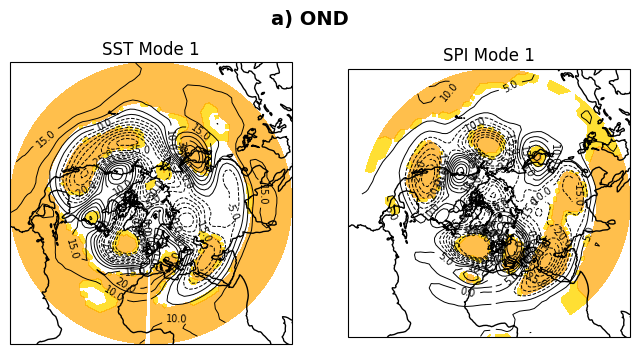

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


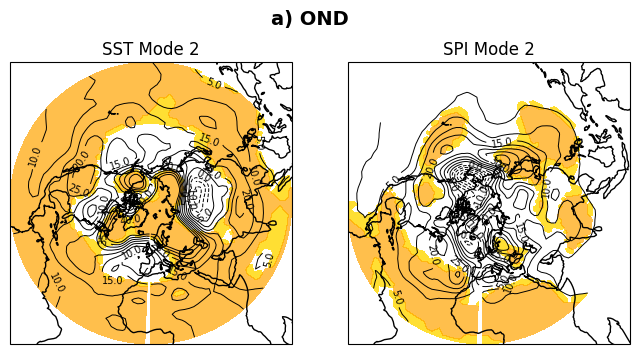

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


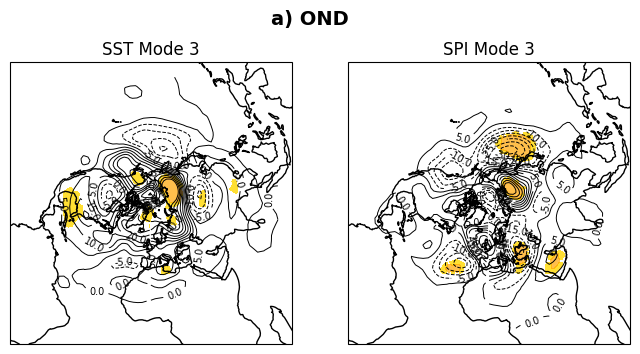

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean Nino3.4 anomaly for month NDJ: -0.017676104328036367


C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


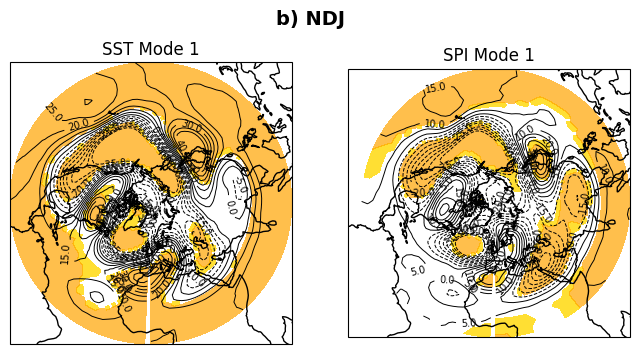

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


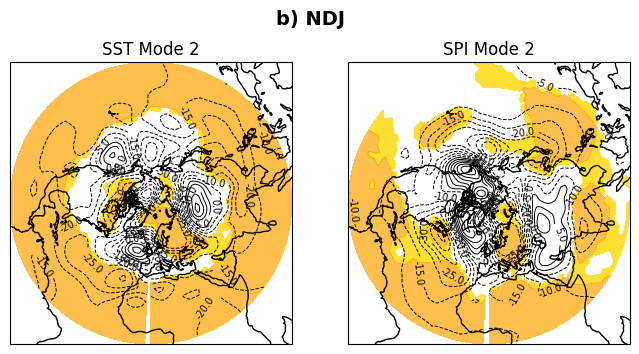

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


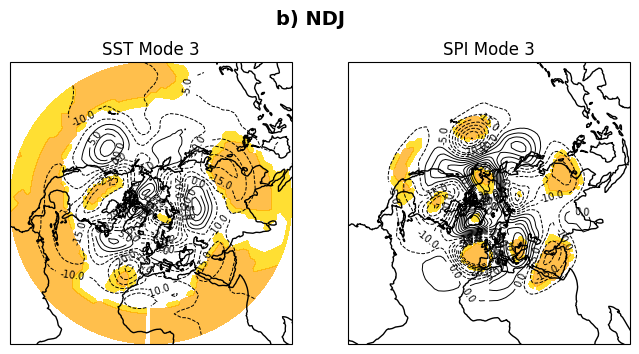

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean Nino3.4 anomaly for month DJF: -0.014909927761677516


C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


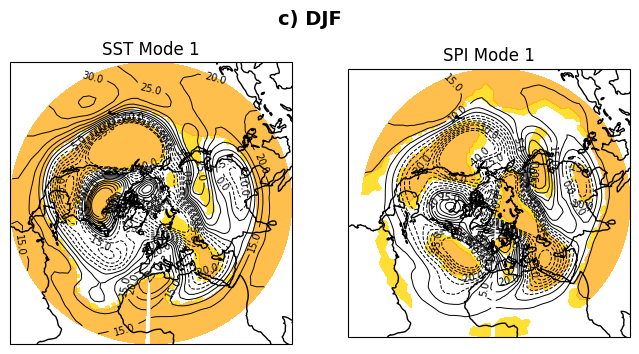

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


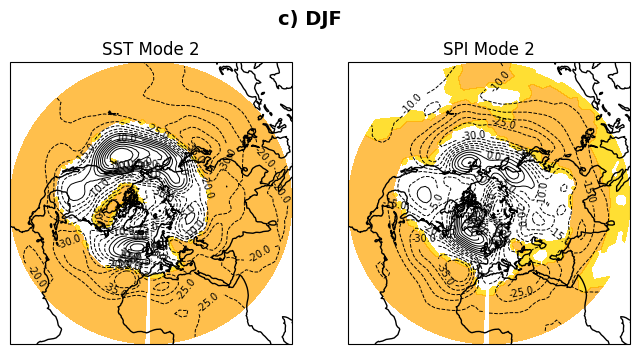

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


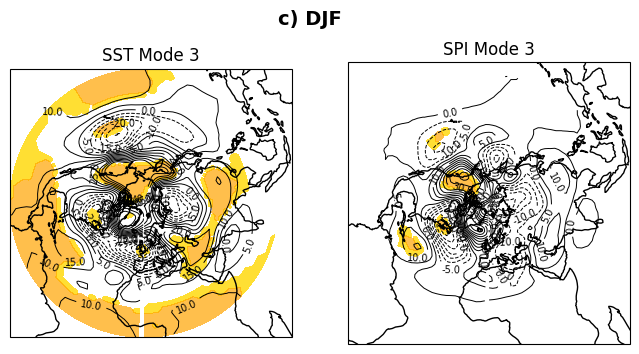

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean Nino3.4 anomaly for month JFM: -0.011938744397215824


C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


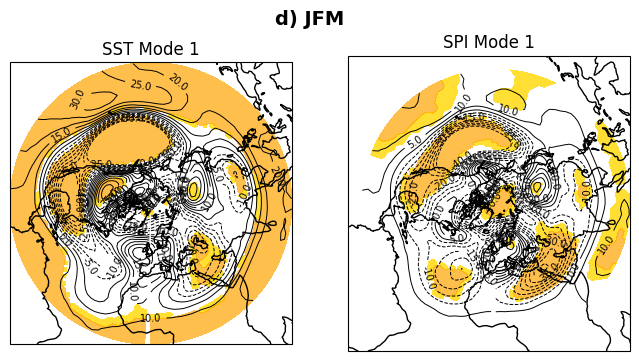

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


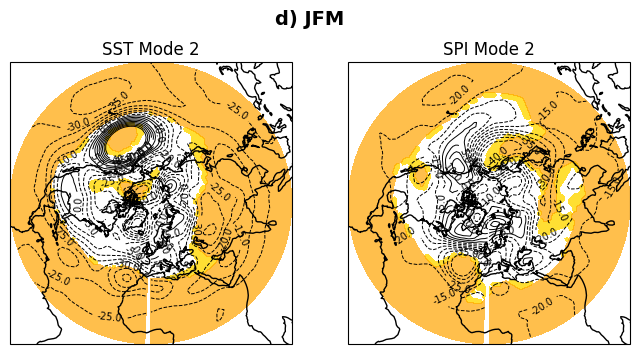

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


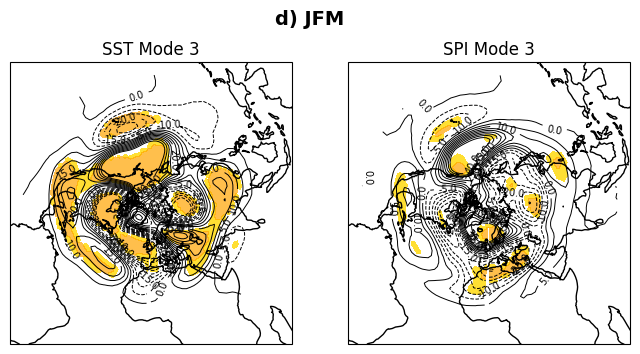

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean Nino3.4 anomaly for month FMA: -0.014561444705758571


C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


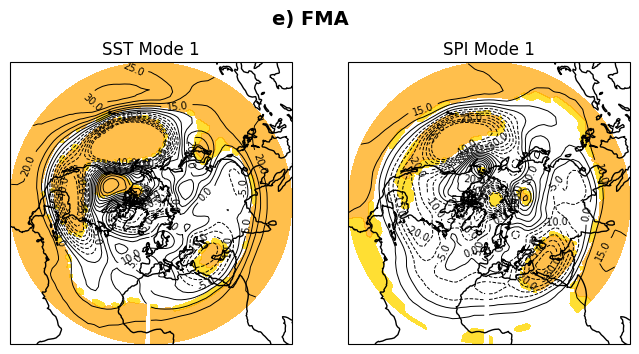

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


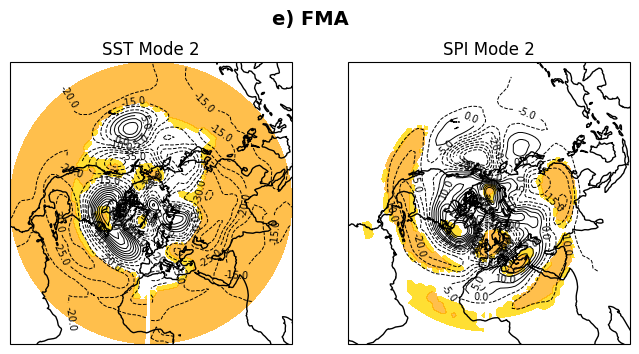

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


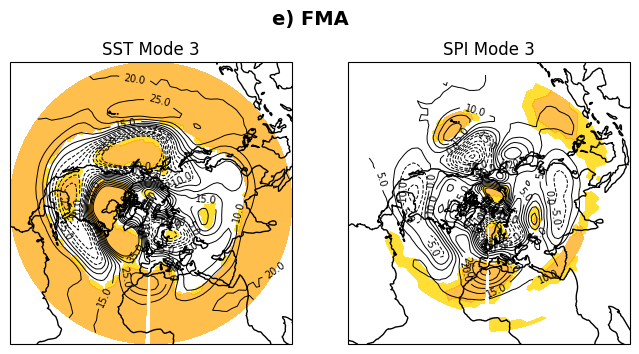

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean Nino3.4 anomaly for month MAM: -0.013904559999617065


C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


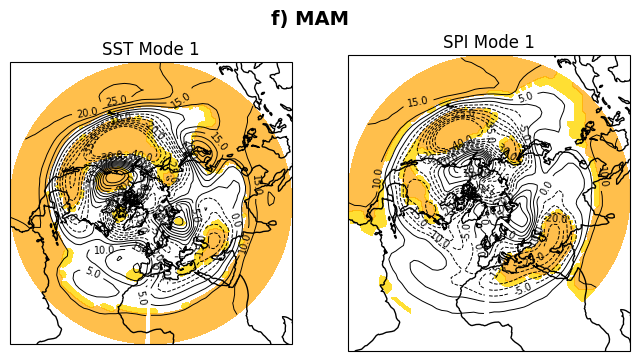

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


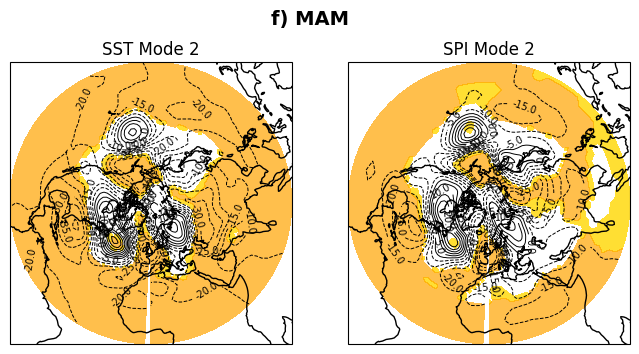

C:\Users\emile\AppData\Local\Temp\ipykernel_20308\1981313670.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


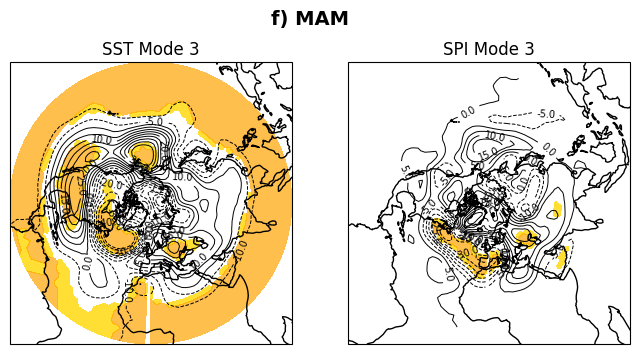

In [12]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for season, label in zip(seasons, labels):
    svd_regression_gph(sst = sst.sst3m, spi=spi, hpa=gph.hgt3m,label=label,
                       detrend=False,norm_preds=True,
                       method='reg',
                       n_modes=3, month=season,proj=ccrs.NorthPolarStereo())
    # svd_regression_gph(sst = sst.sst3m, spi=spi, hpa=gph.hgt3m,label=label,
    #                    detrend=False, norm_preds=True,
    #                    method='corr',
    #                    n_modes=3, month=season,proj=ccrs.NorthPolarStereo())